# Part 5: Recognition

In this part of the assignment, you will practice **object detection** by applying a [pre-trained YOLO model](https://pytorch.org/hub/ultralytics_yolov5/) for object detection on a new dataset. Specifically, you will use a pre-trained YOLO model to detect cars in images derived from video recording of a highway. You will evaluate the model using Intersection over Union (IoU) and recall metrics.

**Learning objectives.** You will:
1. Apply a pre-trained YOLO model for object detection on a new dataset.
2. Evaluate the model using IoU and recall metrics.
3. Consider the ethical implications surrounding bias and privacy for facial recognition software as one example of object detection in the real world.

YOLO (You Only Look Once) is a popular object detection algorithm that is known for its speed and accuracy. YOLO divides the image into a grid and predicts bounding boxes and class probabilities for each grid cell. The model predicts the bounding boxes and class probabilities simultaneously, which makes it faster than other object detection algorithms. YOLO has several versions, such as YOLOv1, YOLOv2, YOLOv3, and YOLOv4. In this assignment, you will use YOLOv5, which is a popular version of the YOLO model. You can [read more about the model and its architecture here](https://docs.ultralytics.com/yolov5/) if you are interested; you will find that it is a deep neural network that uses convolutional layers extensively, among other things.

First, the following code loads the dataset of car images and stores them in a dictionary keyed by the image id.

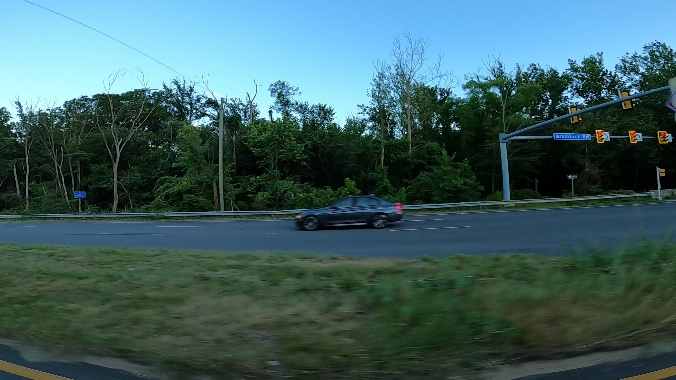

In [3]:
# Run but DO NOT MODIFY this code

# load car images and visualize a sample image
import os
from PIL import Image

# stores images in a dictionary keyed by image_id
path = 'car/car_images'
image_dict = {}
for file in os.listdir(path):
    if file.endswith('.jpg'):
        image_id = file.split('.')[0]
        image = Image.open(os.path.join(path, file))
        image_dict[image_id] = image

image_dict['vid_4_600']

Next, the following code reads the ground truth bounding box information for cars in all of the images. There may be multiple cars in a single image, in which case the dataset has multiple rows, one per car, just sharing the same image id. Images are identified with the same ids as above.

The code as written uses the [Pandas library](https://pandas.pydata.org/). If you prefer not to work with Pandas you are welcome to instead use the Python standard library [csv module](https://docs.python.org/3/library/csv.html) or NumPy to read the data into a structure of your preference.

In [4]:
# load car bounding boxes

import pandas as pd
bounding_boxes = pd.read_csv('car/car_bounding_boxes.csv')
bounding_boxes.head()

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


## Task 1

Below we import a pretrained YOLO model. If you are unable to load the model due to a missing dependency (for example, the model needs access to the `cv2` module for computer vision) then you can try running the following command in a separate notebook cell by itself to attempt to install the dependencies: `pip install -U ultralytics`.

In [5]:
# load pre-trained Yolo model

import torch
import warnings
warnings.filterwarnings("ignore")
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')

Using cache found in /home/users/jco21/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2024-10-21 Python-3.11.5 torch-2.1.0 CUDA:0 (Tesla P100-PCIE-12GB, 12187MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


Once you have loaded the model, use it on any image containing at least one car. Visualize the predicted bounding box on the image. You can see an [example of the basic model usage here](https://pytorch.org/hub/ultralytics_yolov5/#load-from-pytorch-hub); note that running the model returns a custom results object that can be visualized directly with `.show()`.

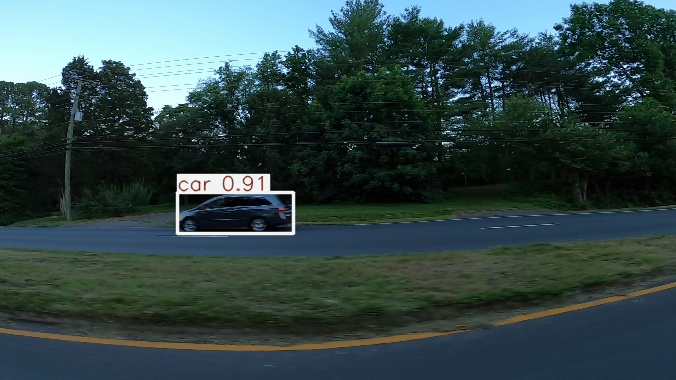

In [6]:
img=image_dict["vid_4_10120"]
result=model(img)
result.show()

## Task 2

The standard way to measure the correctness of a bounding box prediction in object detection is the intersection-over-union (IoU). Given a ground truth bounding box $B$ and a predicted bounding box $\hat{B}$, the IoU is the area of the *intersection* of $B$ and $\hat{B}$ (the number of pixels included in both) divided by the *union* of $B$ and $\hat{B}$ (the total number of pixels included in either). IoU should always be a value between 0 and 1, with larger scores indicating better bounding box predictions.

For this task, implement the `intersect_over_union` function below to calculate the IoU metric. You should then **test your implementation** before moving on, reporting at least 3 examples used for testing.

In [7]:
# write code for task 2 here 

def intersect_over_union(ground_truth, pred):
    x1, y1, x2, y2 = ground_truth
    x1_pred, y1_pred, x2_pred, y2_pred = pred
    x1_int = max(x1, x1_pred)
    y1_int = max(y1, y1_pred)
    x2_int = min(x2, x2_pred)
    y2_int = min(y2, y2_pred)

    intersection_area = max(0, x2_int-x1_int)*max(0, y2_int-y1_int)
    gt_area = (x2-x1)*(y2-y1)
    pred_area = (x2_pred-x1_pred)*(y2_pred-y1_pred)
    union_area = gt_area+pred_area-intersection_area
    if(union_area==0):
        return 0
    iou = intersection_area/union_area
    return iou


In [8]:
examples=["vid_4_10120","vid_4_10020","vid_4_1020"]
for ex in examples:
    print(ex)
    out=model(image_dict[ex]).xyxy[0]
    y_hat=tuple(out[0][:4].tolist())
    name=ex+".jpg"
    y_correct=bounding_boxes[bounding_boxes["image"]==name]
    y=y_correct.iloc[0]
    y_tup=tuple(y_correct.iloc[0][["xmin","ymin","xmax","ymax"]])
    print(f"IOU:{intersect_over_union(y_tup,y_hat)}")

vid_4_10120
IOU:0.5307943626945008
vid_4_10020
IOU:0.49484669649415824
vid_4_1020
IOU:0.5191382055882101


## Task 3

Evaluate the YOLO model by computing and reporting the **recall** of the model's bounding box predictions for cars (and only cars) on the entire dataset. Recall that the recall is the fraction of cars that are correctly detected by the model. A couple things to note:

1. There may be multiple ground truth cars in a given image. When there are multiple cars in a given image, treat each one separately, so that the recall is over all appearances of cars in all images in the dataset.
2. Use the intersection over union metric to determine if a car is correctly detected. Specifically, consider a prediction to be a true positive if the IoU is at least $0.5.$

In [13]:
positives=0
total_cars=0
for img_id, img in image_dict.items():
    out=model(image_dict[img_id]).xyxy[0]
    name=img_id+".jpg"
    y_hat=[]
    for i in out:
        y_hat.append(tuple(i[:4].tolist()))
    y_correct=bounding_boxes[bounding_boxes["image"]==name]
    y_tup=[]
    for i,row in y_correct.iterrows():
        total_cars+=1
        y_tup.append(tuple(row[["xmin","ymin","xmax","ymax"]]))
    for i in y_tup:
        iou=[]
        for box in y_hat:
            iou.append(intersect_over_union(i,box))
        if len(iou)>0 and max(iou)>=.5:
            positives+=1
output=positives/total_cars       
print(f"recall:{output}")   

recall:0.9499105545617174


## Task 4

You may have heard of **facial recognition** software: These are essentially models for object detection and recognition that are trained to detect and recognize human faces. Such models have been deployed in law enforcement and, for example, [US Customs when entering the country](https://www.cbp.gov/travel/biometrics).

Such adoption has happened despite serious ethical objections concerning bias and privacy. For example, [Gender Shades by Buolamwini and Gebru, 2018](https://proceedings.mlr.press/v81/buolamwini18a.html) was a landmark audit study of commercially available facial recognition software that demonstrated substantial disparities in performance based on skin color. 

In 2021, Marks observes in a [Communications of the ACM Article](https://cacm.acm.org/news/can-the-biases-in-facial-recognition-be-fixed-also-should-they/) cases of individuals wrongly accused of crimes on the basis of facial recognition software, including software developed using 2.8 billion scraped images from social media without user permission, raising further questions about privacy. 

Of course, others might argue that properly trained and debiased models might be used to build a safer (by helping to find criminal suspects) or more convenient society (replacing, for example, paper passports). Walsh, in a [2022 article](https://cacm.acm.org/opinion/the-troubling-future-for-facial-recognition-software/) considers a variety of perspectives including the threat of constant surveillance but also the potential for applications of societal benefit.

In 2-3 paragraphs, take a position on the question "Should governments use facial recognition software?" You might argue yes for some purposes but no for others, or that it depends on how the technology is developed or regulated; explain your view referencing any of the above articles or other sources of your own choosing.

I feel as if governments need to be extremely cautious when implementing facial recognition, but if it can be implemented well and fairly, it can be beneficial to reducing crime and decrease bias in the judicial system. With humans being inherintly biased and sometimes wrong, there will always be cases of citizens facing false imprisonment because of mistakes, lacks of evidence, and prejudices. However, facial recognition through the use of ML models has the potential to remove human error from court cases. If trained properly, we could create a model with a high enough accuracy to remove the need of witnesses; however, I place a lot of emphasis on "trained properly." Marks of Communications of the ACM points out current issues with governmental implementations of facial recognition.

Marks points out many different scenarios where facial recognition has caused false imprisonment: Robert Williams arrest in 2020 where he was falsely identified by facial recognition as someone who robbed a store and Michael Oliver's arrest in 2019 where he was accused of stealing a smartphone when facial recognition incorrectly identified him. Both of these men were black and illustrate the current biases within government use of facial recognition ML models. In many circumstances, some groups are underrepresented in datasets, causing false positives. If not trained properly, we could increase the amount of false accusations/arrests made.

At the end of the day, facial recognition shouldn't be relied on until it is fullproof. However, once it is, it can be a great tool.